# Effekten av vindparker til sjøs - Sørvest F 
### Kjersti Stangeland - Sommer 2025 - Meteorologisk Institutt

#### Prosjektet
Et scenario med norske havvindparker er utviklet i samarbeid med NVE. Perioden 2/2-2022 til 30/6-2022 er simulert med MEPS, WaveWatch III, og Norkyst v3. Det er to varianter av simuleringene:
* Kontrollkjøring basert på dagens situasjon uten norske havindparker
* Eskperiment med simulerte havvindparker

I eksperimentene er det kun MEPS som har en direkte parameterisering av turbineffekter, slik at påvirkningen på bølgene og havsirkulasjonen er indirekte gjennom endrede overflateflukser.

__Detaljer om havvind-parkene__
* Turbinhøyde 165 m
* Radius 143 m
* 2.5 km mellom turbinene

__Sørvest F (trolig utdatert info)__
* 4 x 64 turbiner
* Total kapasitet på 5632 MW


In [ ]:
%load_ext autoreload
%autoreload 2

import pickle
from numba import njit, prange

from possible_trash.plotting_funcs import*
from pre_process import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#test = xroms.open_mfnetcdf(['/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0001.nc','/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0002.nc', '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0003.nc'])

test = xroms.open_mfnetcdf(['/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-02/norkyst_avg_0001.nc', 
                            '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-03/norkyst_avg_0001.nc',
                            '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-04/norkyst_avg_0001.nc',
                            '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-05/norkyst_avg_0001.nc',
                            '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0001.nc'])

test, xgrid = xroms.roms_dataset(test, include_cell_volume=True)

In [4]:
# Reading in the turbine coordinates
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [5]:
# Find coordinates of midpoint of Sørvest F
target_lon = 5.0
target_lat = 56.8

i_loc, j_loc = get_windpark_midpoint_indices(test, target_lon, target_lat)

### Beregning av midlere intern Rossbyradie

For videre utregninger er det fint å avgrense modellområdet. Ved å bruke den interne Rossbyradien, kan vi med trygghet avgrense området slik at vi er sikre på at den relevante dynamikken kommer med. I vårt tilfelle er vi interesert i å avgrense et området av skala 1-2 deformasjonsradier slik at dynamikken i området er dominert av interne barokline instabiliterer. (???)
Rossbyradien sier noe om deformasjonslengden av bølger. Det vil si, en lengdeskala hvor jordens rotasjon påvirker strømningene og man har geostrofisk balanse.

Sperrevik et al. (2017) beregner den interne Rossbyradien på følgende måte:
$$R_1 = \frac{c_1}{\mid f \mid}$$
hvor $f$ er det lokale Coriolis parameterte og $c_1$ er fasehastigheten til første modus av baroklinisk intern gravitasjonsbølge. Fasehastigheten kan beregnes ved å løse et egenverdi problem, men Chelton et al. (1998) tilbyr en approksimasjon kalt WKB løsning:
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Her er $H$ den lokale vanndybden og $N$ oppdriftsfrekvens.

Sperrevik et al. (2017) beregnet den interne Rossby radien for området utenfor Lofoten, som ses i figuren under.

![Sperrevik et al. (2017)](Sperrevik_etal_2017_fig5.png)

Her ser vi deformasjonsradien for vårmånedene 1984. Radien har sitt minimum etter vinteren, og øker mot sommeren grunnet sterkere stratifikasjon. Jeg bruker denne figuren som referanse for å se om verdiene jeg får ut ser fornuftige ut.

__Forsøk 1__
Brukte xroms sin egen pakke for å beregne N2. Interpolerte til z dyp ved xroms.zslice. Metoden tar per nå ikke inn lokal vanndyp, eller? Integrerte N ved xarray sin  integrate funksjon. Siden xroms.N2 gir output på s_w punkter skjer integreringen på z_w punkter. Usikker om det er riktig.

In [31]:
R_test = rossby_radius(test.f, test.rho, test.z_w, xgrid)

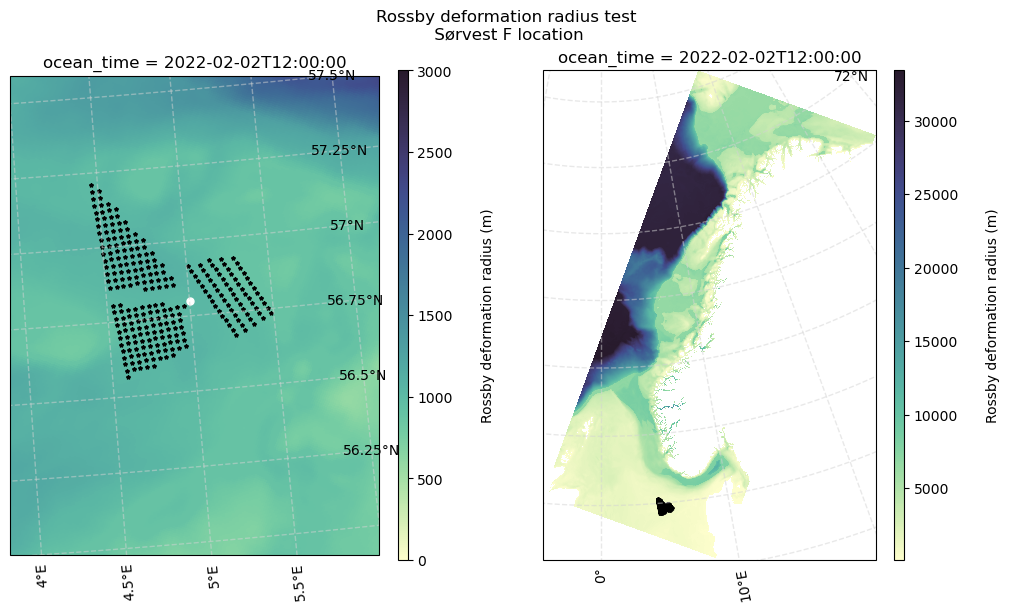

In [32]:
plot_map_Rossby_radius(ds=test, R=R_test, windpark=sorvest_F, exp_name='test', 
    time_idx=0, i_loc=i_loc, j_loc=j_loc)

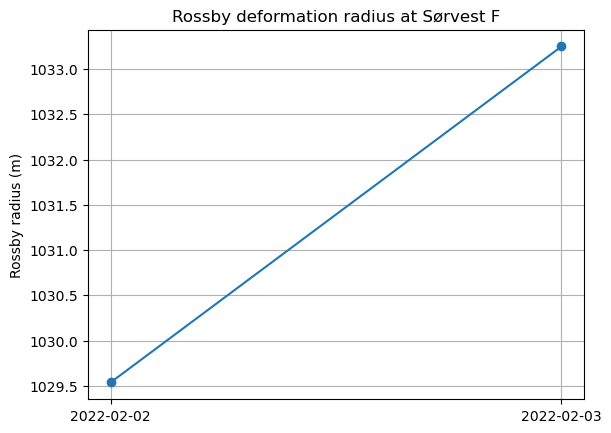

In [33]:
fig, ax = plt.subplots()

ax.plot(test.ocean_time, R_test.isel(eta_rho=i_loc, xi_rho=j_loc).values, marker='o')

ax.set_ylabel('Rossby radius (m)')
ax.set_title('Rossby deformation radius at Sørvest F')

ax.set_xticks(test.ocean_time, rotation=45)

ax.grid(True)

__Forsøk 2__

Bruker Ann Kristin sin funksjon for å beregne N2. Integrering av N ved np.trapz. Sender rho sammen med z_rho inn i N2 funksjonen. 

In [ ]:
""" rho_test = test.rho
z_test = test.z_rho
f_test = test.f """

In [ ]:
""" z_test = z_test.transpose('s_rho', 'ocean_time', 'eta_rho', 'xi_rho')
rho_test = rho_test.transpose('s_rho', 'ocean_time', 'eta_rho', 'xi_rho')
f_test = f_test.transpose('eta_rho', 'xi_rho') """

In [ ]:
#R_testing = get_rossby_radius(rho_test, z_test, f_test)

In [ ]:
""" proj = ccrs.Mercator()
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': proj}, constrained_layout=True)

ax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
plot1 = ax[0].pcolormesh(test.lon_rho, test.lat_rho, R_testing[0, :, :], 
                         transform=ccrs.PlateCarree(), shading='auto', 
                         vmin=0, vmax=3000, cmap='cmo.deep') 
cbar1 = plt.colorbar(plot1, ax=ax[0], orientation='vertical', pad=0.05, aspect=30, shrink=0.7) 
cbar1.set_label('Rossby deformation radius (m)', labelpad=20)
cbar1.ax.tick_params(labelsize=10)

plot = ax[1].pcolormesh(test.lon_rho, test.lat_rho, R_testing[0, :, :], 
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap='cmo.deep')
cbar = plt.colorbar(plot, ax=ax[1], orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label('Rossby deformation radius (m)', labelpad=20)
cbar.ax.tick_params(labelsize=10)


for axs in ax.flatten():
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=3) 

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    axs.add_feature(cartopy.feature.COASTLINE, alpha=0.5)

ax[0].set_title('Sørvest F')
ax[1].set_title('Full domain')
fig.suptitle('Rossby deformation radius')
 """

In [ ]:
""" fig, ax = plt.subplots()

ax.plot(test.ocean_time, R_testing[:, i_loc, j_loc], marker='o')

ax.set_ylabel('Rossby radius (m)')
ax.set_title('Rossby deformation radius at Sørvest F')

ax.set_xticks(test.ocean_time, rotation=45)

ax.grid(True)

fig.suptitle('Rossby deformation - another approach') """

Plot av batymetri

In [ ]:
""" proj = ccrs.Mercator()
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': proj}, constrained_layout=True)

ax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
plot1 = ax[0].pcolormesh(test.lon_rho, test.lat_rho, test.h[:,:], 
                         transform=ccrs.PlateCarree(), shading='auto', 
                         vmin=0, vmax=100, cmap='cmo.deep') 
cbar1 = plt.colorbar(plot1, ax=ax[0], orientation='vertical', pad=0.05, aspect=30, shrink=0.7) 
cbar1.set_label('Rossby deformation radius (m)', labelpad=20)
cbar1.ax.tick_params(labelsize=10)

plot = ax[1].pcolormesh(test.lon_rho, test.lat_rho, test.h[:,:], 
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap='cmo.deep')
cbar = plt.colorbar(plot, ax=ax[1], orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label('Rossby deformation radius (m)', labelpad=20)
cbar.ax.tick_params(labelsize=10)


for axs in ax.flatten():
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=3) 

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    axs.add_feature(cartopy.feature.COASTLINE, alpha=0.5)

ax[0].set_title('Sørvest F')
ax[1].set_title('Full domain')
fig.suptitle('Ocean floor bathymetry') """


In [ ]:
print(f'Havdybde i Sørvest F: {test.h[i_loc, j_loc].values} m')

Området rundt vindparken er relativt grunt. For deformasjonsradien som er tilnærmet lineært avhengig av lokal vanndybde, kan derfor radien være liten sammenlignet med verdier utenfor kontinetalsokkelen. Radien avhenger også av oppdriftsfrekvensen. Er vannmassene i snitt sterkt stratifisert, vil dette øke radien. Mer barotropiske vannkolonner vil ha lavere oppdriftsfrekvens og også lavere deformasjonsradie. 

__Forsøk 3__
Her prøver jeg å herme direkte etter Ann Kristin i alle deler av utregningen. Først lager jeg et array av z dyp jeg vil interpolere til. Deretter interpolerer jeg density fra s lag til gitte z lag. Så for å beregne Rossby radien: Først regne ut N2 (samme funkjson som i metode b), deretter integrere N over z. Det viser seg å være vanskelig grunnet dimensjonene. Vil integrere N over lokalt dyp i hvert grid punkt. Ettersom loop-ene kan bli ganske store, virker det som om at det er raskere å konvertere alt fra xarrat.DataArray til vanlig numpy array. Men det er per nå en del kluss. Prøvde å legge til numba sin @njit for å gjøre det raskere. Det funka ekstremt bra på interpoleringsdelen, da gikk det fra 36 min til 1 min! Men grunnet mye MemoryError så har jeg per nå ikke klart å sjekke om interpoleringen faktisk var rikitg eller seg fornuftig ut. 

In [ ]:
# Variables needed for calculating Rossby deformation radius
ocean_time = test.ocean_time  # time stamp
density = test.rho.values  
f = test.f.values  # Coriolis parameter
h = test.h.values  # Bathymetry
mask = test.mask_rho.values  # Land mask
z_r = test.z_rho.values  # Depth of rho points

In [ ]:
# Making depth levels to interpolate to
zlevs = np.arange(0, 51, 1)
zlevs = np.insert(zlevs, len(zlevs), values=np.arange(52, 102, 2), axis=0)
zlevs = np.insert(zlevs, len(zlevs), values=np.arange(105, 305, 5), axis=0)
zlevs = np.insert(zlevs, len(zlevs), values=np.arange(520, 2020, 20), axis=0)
#zlevs = zlevs[np.where(zlevs <= np.max(h))]
zlevs = np.array(zlevs) * -1.

In [ ]:
#density_zlevs = dens_to_zlevs(density, z_r, zlevs, mask)

In [ ]:
#np.save('density_zlevs.npy', density_zlevs)

In [ ]:
# memory error :((((
#rossby_radius = calc_rossby_radius(density_zlevs, zlevs, f)

In [ ]:
test.mask_rho.plot()

In [ ]:
@njit
def t_interpolate_density_on_zlevs(dens, z_r, zlevs, mask, time_index):
    """
    Interpolate density from s-layers to specified z-levels for one time step.

    Parameters:
    dens: numpy.ndarray
        Density array with shape (time, vertical levels, y, x)
    z_r: numpy.ndarray
        Depth array with shape (time, vertical levels, y, x)
    zlevs: numpy.ndarray
        Target depth levels for interpolation
    mask: numpy.ndarray
        Boolean mask for valid grid points
    time_index: int
        The index of the time step to process

    Returns:
    numpy.ndarray
        Interpolated density at specified z-levels with NaNs where zlevs are not valid
    """
    # Initialize a temporary array for the interpolated densities
    tmp_density = np.full((len(zlevs), dens.shape[2], dens.shape[3]), np.nan)
    
    for y in range(dens.shape[2]):
        for x in range(dens.shape[3]):
            # Skip grid points on land
            if mask[y, x]==0:
                continue
            
            # Get depth points and densities for the specified time index and location
            depth_points = z_r[time_index, :, y, x]
            density_values = dens[time_index, :, y, x]
            z_min = depth_points.min()  # Minimum depth for the current grid cell
            
            # Check for valid zlevs that are greater than z_min
            valid_zlevs = zlevs[zlevs > z_min]

            # Ensure we have enough valid levels to interpolate
            if valid_zlevs.size == 0:
                continue
            
            # Perform interpolation
            density_interpolated = np.full(valid_zlevs.shape, np.nan)
            for i in range(len(valid_zlevs)):
                z_level = valid_zlevs[i]
                # Perform interpolation manually (since griddata is not supported)
                idx = np.searchsorted(depth_points, z_level)
                if idx > 0 and idx < len(depth_points):
                    t = (z_level - depth_points[idx - 1]) / (depth_points[idx] - depth_points[idx - 1])
                    density_interpolated[i] = density_values[idx - 1] + t * (density_values[idx] - density_values[idx - 1])
            
            # Fill the appropriate positions in tmp_density with the interpolated values
            for i, z_level in enumerate(valid_zlevs):
                # Check if z_level exists in zlevs
                for j in range(len(zlevs)):
                    if zlevs[j] == z_level:
                        tmp_density[j, y, x] = density_interpolated[i]  # Fill the respective depth
                        break  # Found and set value, exit the inner loop

    return tmp_density  # Return your interpolated densities

@njit
def t_dens_to_zlevs(dens, z_r, zlevs, mask):
    """
    Interpolate density from s-layers to specified z-levels for all time steps.

    Parameters:
    dens: numpy.ndarray
        Density array with shape (time, vertical levels, y, x)
    z_r: numpy.ndarray
        Depth array with shape (time, vertical levels, y, x)
    zlevs: numpy.ndarray
        Target depth levels for interpolation
    mask: numpy.ndarray
        Boolean mask for valid grid points

    Returns:
    numpy.ndarray
        Interpolated density at specified z-levels for all time steps
    """
    time_steps = dens.shape[0]
    result_density = np.full((time_steps, zlevs.shape[0], dens.shape[2], dens.shape[3]), np.nan)

    for t in range(time_steps):
        result_density[t] = t_interpolate_density_on_zlevs(dens, z_r, zlevs, mask, t)

    return result_density  # Return all interpolated densities for all time steps


In [ ]:
@njit
def t_interpolate_density_on_zlevs(dens, z_r, zlevs, mask, time_index):
    tmp_density = np.full((len(zlevs), dens.shape[2], dens.shape[3]), np.nan)
    
    for y in range(dens.shape[2]):
        for x in range(dens.shape[3]):
            if mask[y, x] == 0:
                continue
            
            depth_points = z_r[time_index, :, y, x]
            density_values = dens[time_index, :, y, x]
            z_min = depth_points.min()  
            valid_zlevs = zlevs[zlevs > z_min]

            if valid_zlevs.size == 0:
                continue
            
            density_interpolated = np.full(valid_zlevs.shape, np.nan)

            for i in range(valid_zlevs.size):
                z_level = valid_zlevs[i]

                idx = np.searchsorted(depth_points, z_level)

                if idx > 0 and idx < len(depth_points):
                    t = (z_level - depth_points[idx - 1]) / (depth_points[idx] - depth_points[idx - 1])
                    density_interpolated[i] = density_values[idx - 1] + t * (density_values[idx] - density_values[idx - 1])

            for i, z_level in enumerate(valid_zlevs):
                for j in range(len(zlevs)):
                    if zlevs[j] == z_level:
                        tmp_density[j, y, x] = density_interpolated[i]
                        break 

    return tmp_density 

@njit
def t_dens_to_zlevs(dens, z_r, zlevs, mask):
    time_steps = dens.shape[0]
    result_density = np.full((time_steps, zlevs.shape[0], dens.shape[2], dens.shape[3]), np.nan)

    for t in range(time_steps):
        result_density[t] = t_interpolate_density_on_zlevs(dens, z_r, zlevs, mask, t)

    return result_density 


In [ ]:
t_density_zlevs = t_dens_to_zlevs(density, z_r, zlevs, mask)

In [ ]:
test['rho_inter'] = xr.DataArray(t_density_zlevs, dims=('ocean_time', 'zlevs', 'eta_rho', 'xi_rho'))

In [ ]:
test.rho_inter.isel(ocean_time=0, zlevs=0).plot()

In [ ]:
np.nanmax(t_density_zlevs)

In [ ]:
@njit
def t_N2(rho_, z_, rho_0=1000.0):
    '''
    Return the stratification frequency N2

    Parameters
    ----------
    rho : array_like
        density [kg/m^3]
    z : array_like
        depths [m] (positive upward)

    Returns
    -------
    N2 : array_like
        Stratification frequency [1/s]
    '''
    rho = np.asarray(rho_)
    z = np.asarray(z_)

    assert rho.shape == z.shape, 'rho and z must have the same shape.'
    
    # Manual calculation of differences since np.diff is not supported
    r_z = np.empty(rho.shape[0] - 1)
    for i in range(len(r_z)):
        r_z[i] = (rho[i + 1] - rho[i]) / (z[i + 1] - z[i])

    buoy_freq_sq = -(9.8 / rho_0) * r_z

    return buoy_freq_sq


In [ ]:
@njit
def trapezoidal_rule(y, x):
    """Simple trapezoidal integration."""
    return (x[1] - x[0]) * 0.5 * (y[0] + y[-1]) + (x[1] - x[0]) * np.sum(y[1:-1])


def t_calc_rossby_radius(dens, z, f):
    """
    Calculate the Rossby radius based on buoyancy frequency N integrated over depth.

    Parameters
    ----------
    dens : array_like
        Density profile [kg/m^3] with shape (cz, y, x), cz represents depth levels.
    z : array_like
        Depth levels corresponding to density [m] (should be positive upward).
    f : array_like
        Coriolis parameter [1/s] with the same dimensions as y and x.

    Returns
    -------
    R : array_like
        Rossby radius [m] with the same dimensions as f.
    """
    # Initialize an array for Rossby radius results
    R = np.zeros((dens.shape[0], dens.shape[2], dens.shape[3]))  # Shape same as mask or original grid

    # Calculate N^2 for all depth levels
    n2 = np.empty((dens.shape[0], dens.shape[1]-1, dens.shape[2], dens.shape[3]))  # Initialize with NaNs 
    
    for y in prange(dens.shape[2]):  # Iterate over y
        for x in range(dens.shape[3]):  # Iterate over x
            for i in range(dens.shape[0]):  # Iterate over time
                n2[i, :, y, x] = t_N2(dens[i, :, y, x], z)  # Ensure N2 computation calls the correct version

    # Avoid negative values
    n2[n2 < 0] = .0000001

    # Calculate buoyancy frequency N
    N = np.sqrt(n2)

    # Integration over depth using the trapezoidal rule for each grid point
    for y in prange(N.shape[2]):
        for x in range(N.shape[3]):
            # For each grid point, check for valid N values
            valid = False
            integral = np.zeros((N.shape[0], N.shape[2], N.shape[3]))  # Initialize integral array
            for i in range(N.shape[0]):
                if not np.isnan(N[i, :, y, x]).all():
                    valid = True
                    integral[i, y, x] += trapezoidal_rule(N[i, :, y, x], z)  # Integrate N with respect to z

            # Calculate Rossby radius only if there are valid N values
            if valid:
                if np.abs(f[y, x]) > 0:
                    for i in range(N.shape[0]):
                        R[i, y, x] = integral[i, y, x] / (np.abs(f[y, x]) * np.pi)

    return R  # Return the computed Rossby radius


In [ ]:
@njit
def trapezoidal_rule(y, x):
    """Simple trapezoidal integration."""
    return (x[1] - x[0]) * 0.5 * (y[0] + y[-1]) + (x[1] - x[0]) * np.sum(y[1:-1])

def t_calc_rossby_radius(dens, z, f):
    """
    Calculate the Rossby radius based on buoyancy frequency N integrated over depth.

    Parameters
    ----------
    dens : array_like
        Density profile [kg/m^3] with shape (cz, y, x), cz represents depth levels.
    z : array_like
        Depth levels corresponding to density [m] (should be positive upward).
    f : array_like
        Coriolis parameter [1/s] with the same dimensions as y and x.

    Returns
    -------
    R : array_like
        Rossby radius [m] with the same dimensions as f.
    """
    # Initialize an array for Rossby radius results
    R = np.zeros((dens.shape[0], dens.shape[2], dens.shape[3]))  # Time, y, x

    # Calculate N^2 for all depth levels
    n2 = np.empty((dens.shape[0], dens.shape[1] - 1, dens.shape[2], dens.shape[3]))  # Initialize with NaNs 

    # Calculate N^2 with parallel processing over y and x
    for y in prange(dens.shape[2]):
        for x in range(dens.shape[3]):
            for i in range(dens.shape[0]):  # Iterate over time
                n2[i, :, y, x] = t_N2(dens[i, :, y, x], z)  # Compute N2

    # Avoid negative values
    n2[n2 < 0] = .0000001

    # Calculate buoyancy frequency N
    N = np.sqrt(n2)

    # Integration over depth using the trapezoidal rule for each grid point
    for y in prange(N.shape[2]):
        for x in range(N.shape[3]):
            integral = np.zeros(N.shape[0])  # Initialize integral for each time index
            for i in range(N.shape[0]):
                if not np.isnan(N[i, :, y, x]).all():  # Check if N has any valid entries
                    integral[i] = trapezoidal_rule(N[i, :, y, x], z)  # Integrate N with respect to z

            # Calculate Rossby radius only if there are valid N values
            if np.any(~np.isnan(N[:, :, y, x])):  # Check if there's at least one valid N
                if np.abs(f[y, x]) > 0:
                    for i in range(N.shape[0]):
                        R[i, y, x] = integral[i] / (np.abs(f[y, x]) * np.pi)

    return R  # Return the computed Rossby radius


In [ ]:
t_rossby_radius = t_calc_rossby_radius(t_density_zlevs, zlevs, f)

In [ ]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': proj}, constrained_layout=True)

ax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
plot1 = ax[0].pcolormesh(test.lon_rho, test.lat_rho, t_rossby_radius[0, :, :], 
                         transform=ccrs.PlateCarree(), shading='auto', 
                         vmin=0, vmax=3000, cmap='cmo.deep') 
cbar1 = plt.colorbar(plot1, ax=ax[0], orientation='vertical', pad=0.05, aspect=30, shrink=0.7) 
cbar1.set_label('Rossby deformation radius (m)', labelpad=20)
cbar1.ax.tick_params(labelsize=10)

plot = ax[1].pcolormesh(test.lon_rho, test.lat_rho, t_rossby_radius[0, :, :], 
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap='cmo.deep')
cbar = plt.colorbar(plot, ax=ax[1], orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label('Rossby deformation radius (m)', labelpad=20)
cbar.ax.tick_params(labelsize=10)


for axs in ax.flatten():
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=3) 

    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    axs.add_feature(cartopy.feature.COASTLINE, alpha=0.5)

ax[0].set_title('Sørvest F')
ax[1].set_title('Full domain')
fig.suptitle('Rossby deformation radius')

In [ ]:
fig, ax = plt.subplots()

ax.plot(test.ocean_time, t_rossby_radius[:, i_loc, j_loc], marker='o')

ax.set_ylabel('Rossby radius (m)')
ax.set_title('Rossby deformation radius at Sørvest F')

ax.set_xticks(test.ocean_time, rotation=45)

ax.grid(True)

fig.suptitle('Rossby deformation - another approach')